### Importing necessary libraries

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import unicodedata

import numpy as np
from tqdm import tqdm, trange

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, Dropout, Bidirectional

%matplotlib inline

### Read data to get the number of words and tags

In [ ]:
data = pd.read_csv("amh/train.txt", encoding="utf-8", sep = " ", names=["Word", "Tag"])
data.head(10)

,Word,Tag
0,ቀዳሚው,O
1,የሶማሌ,B-LOC
2,ክልል,I-LOC
3,በአወዳይ,I-LOC
4,ከተማ,I-LOC
5,ለተገደሉ,O
6,የክልሉ,O
7,ተወላጆች,O
8,ያከናወነው,O
9,የቀብር,O


In [ ]:
test_data = pd.read_csv("amh/test.txt", encoding="utf-8", sep = " ", names=["Word", "Tag"])
test_data.head(10)

,Word,Tag
0,በአንፃሩ,O
1,ሁሉ,O
2,ሰላም,O
3,እንደነበር,O
4,የሌንዱ,O
5,ጎሳ,O
6,ቃል,O
7,አቀባይ,O
8,ፍራንስዋ,B-PER
9,ዳዳ,I-PER


## Data Preprocessing

### A method to extract the words along with their named entities and read into an array for all sentences

In [ ]:
def split_text_label(filename):
    f = open(filename, encoding = "utf-8")
    split_labeled_text = []
    sentence = []

    for line in f:
        if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
            if len(sentence) > 0:
                split_labeled_text.append(sentence)
                sentence = []
            continue
        splits = line.split(' ')
        sentence.append([splits[0],splits[-1].rstrip("\n")])

    if len(sentence) > 0:
        split_labeled_text.append(sentence)
        sentence = []
    return split_labeled_text

In [ ]:
sentences = split_text_label(os.path.join('amh/train.txt'))
print("First 2 sentences in a word list format:\n",sentences[0:2])

First 2 sentences in a word list format:
 [[['ቀዳሚው', 'O'], ['የሶማሌ', 'B-LOC'], ['ክልል', 'I-LOC'], ['በአወዳይ', 'I-LOC'], ['ከተማ', 'I-LOC'], ['ለተገደሉ', 'O'], ['የክልሉ', 'O'], ['ተወላጆች', 'O'], ['ያከናወነው', 'O'], ['የቀብር', 'O'], ['ስነ', 'O'], ['ስርዓትን', 'O'], ['የተመለከተ', 'O'], ['ዘገባ', 'O'], ['ነው', 'O'], ['፡፡', 'O']], [['ሰማያዊ', 'B-ORG'], ['ፓርቲ', 'I-ORG'], ['ዛሬ', 'B-DATE'], ['በወቅታዊ', 'O'], ['የሀገሪቱ', 'O'], ['የፖለቲካ', 'O'], ['ጉዳዮች', 'O'], ['ላይ', 'O'], ['በመኢአድ', 'B-ORG'], ['ጽህፈት', 'I-ORG'], ['ቤት', 'I-ORG'], ['የሰጠው', 'O'], ['ጋዜጣዊ', 'O'], ['መግለጫ', 'O'], ['ይከተላል', 'O'], ['፡፡', 'O']]]


In [ ]:
split_test = split_text_label(os.path.join('amh/test.txt'))
print("First 2 sentences in a word list format:\n",split_test[0:2])

First 2 sentences in a word list format:
 [[['በአንፃሩ', 'O'], ['ሁሉ', 'O'], ['ሰላም', 'O'], ['እንደነበር', 'O'], ['የሌንዱ', 'O'], ['ጎሳ', 'O'], ['ቃል', 'O'], ['አቀባይ', 'O'], ['ፍራንስዋ', 'B-PER'], ['ዳዳ', 'I-PER'], ['ገልጾዋል', 'O'], ['።', 'O']], [['ጊዜ', 'O'], ['ራሱ', 'O'], ['በጎሳዎቹ', 'O'], ['መካከል', 'O'], ['ያለው', 'O'], ['ልዩነት', 'O'], ['እንዲቆም', 'O'], ['ድርሻ', 'O'], ['አበርክቶዋል', 'O'], ['።', 'O']]]


In [ ]:
split_valid = split_text_label(os.path.join('amh/dev.txt'))

### Determine biggest sentence (which can be later used for maximum length)

In [ ]:
print(len(sentences))
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))

1750
biggest sentence has 21 words


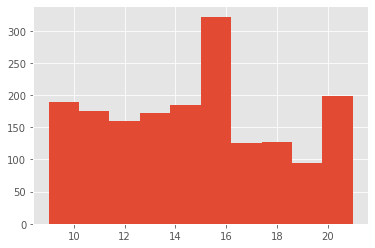

In [ ]:
plt.hist([len(sen) for sen in sentences])
plt.show()

#### Creating Word & Tag dictionary for the later use
- Unique words
- Word and Tag indices

In [ ]:
print("Uniques words in Training set:\n",data.nunique())
print("\nUniques words in Test set:\n",test_data.nunique())

Uniques words in Training set:
 Word    10875
Tag         9
dtype: int64

Uniques words in Test set:
 Word    3990
Tag        9
dtype: int64


In [ ]:
words = list(set(data["Word"].append(test_data["Word"]).values))
words.append("ENDPAD")

words = [unicodedata.normalize('NFKD', str(w)).encode('ascii','ignore') for w in words]
n_words = len(words)
print("\nLength of vocabulary = ",n_words)

tags = list(set(data["Tag"].values))
n_tags = len(tags)

print("\nnumber of tags = ",n_tags)


Length of vocabulary =  13151

number of tags =  9


In [ ]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

### Feature Extraction

In [ ]:
max_len = 30
LSTM_N = 512
BS=32

In [ ]:
X = [[word2idx[unicodedata.normalize('NFKD', str(w[0])). encode('ascii','ignore')] for w in s] for s in sentences]
X_test = [[word2idx[unicodedata.normalize('NFKD', str(w[0])).encode('ascii','ignore')] for w in s] for s in split_test]

X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)
X_test = pad_sequences(maxlen=max_len, sequences=X_test, padding="post", value=n_words - 1)

In [ ]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
y = [to_categorical(i, num_classes=n_tags) for i in y]

### Model - Bidirectional LSTM
- 30 dimensional word indices as input
- 30 embedding layer generation
- Bi-LSTM
- softmax output layer

In [ ]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=max_len, input_length=max_len)(input)
model = Dropout(0.2)(model)
model = Bidirectional(LSTM(units=LSTM_N, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model) #
model = Model(input, out)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X, np.array(y), batch_size=BS, epochs=10, validation_split=0.05, verbose=1)

Epoch 1/10
52/52 [==============================] - 84s 1s/step - loss: 0.6136 - accuracy: 0.8977 - val_loss: 0.4738 - val_accuracy: 0.9261
Epoch 2/10
52/52 [==============================] - 69s 1s/step - loss: 0.4279 - accuracy: 0.9238 - val_loss: 0.3841 - val_accuracy: 0.9261
Epoch 3/10
52/52 [==============================] - 70s 1s/step - loss: 0.3798 - accuracy: 0.9238 - val_loss: 0.3600 - val_accuracy: 0.9261
Epoch 4/10
52/52 [==============================] - 74s 1s/step - loss: 0.3641 - accuracy: 0.9238 - val_loss: 0.3565 - val_accuracy: 0.9261
Epoch 5/10
52/52 [==============================] - 71s 1s/step - loss: 0.3580 - accuracy: 0.9238 - val_loss: 0.3512 - val_accuracy: 0.9261
Epoch 6/10
52/52 [==============================] - 76s 1s/step - loss: 0.3557 - accuracy: 0.9238 - val_loss: 0.3488 - val_accuracy: 0.9261
Epoch 7/10
52/52 [==============================] - 75s 1s/step - loss: 0.3529 - accuracy: 0.9238 - val_loss: 0.3445 - val_accuracy: 0.9261
Epoch 8/10
52/52 [==

In [ ]:
model.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 30)]              0         
                                                                 
 embedding_22 (Embedding)    (None, 30, 30)            394530    
                                                                 
 dropout_22 (Dropout)        (None, 30, 30)            0         
                                                                 
 bidirectional_22 (Bidirecti  (None, 30, 1024)         2224128   
 onal)                                                           
                                                                 
 time_distributed_22 (TimeDi  (None, 30, 9)            9225      
 stributed)                                                      
                                                                 
Total params: 2,627,883
Trainable params: 2,627,883
Non-tr

In [ ]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [ ]:
# Predicting on trained model
pred = model.predict(X_test, verbose=1)
print("Predicted Probabilities on Test Set:\n",pred.shape)
# taking tag class with maximum probability
pred_index = np.argmax(pred, axis=-1)
print("Predicted tag indices: \n",pred_index.shape)

16/16 [==============================] - 4s 273ms/step
Predicted Probabilities on Test Set:
 (500, 30, 9)
Predicted tag indices: 
 (500, 30)


In [ ]:
idx2tag = {i: w for w, i in tag2idx.items()}
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out
def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out

In [ ]:
pred_labels = pred2label(pred)
test_labels = test2label(pred_index [:29*BS])
print(classification_report(test_labels, pred_labels))